In [29]:
# import libraries
import uproot3 as uproot
import uproot as uproot4
import numpy as np
import numba
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from sklearn.cluster import KMeans
import random
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from lmfit import Model
import copy
import math
from tqdm import tqdm

#import ROOT
#from coffea import hist

In [30]:
# Process Data
def getData(fname="", procName="Events"):
    kn_dict = uproot.open(fname)["Events"].arrays()
    kn_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in kn_dict.items()}
    kn_events = ak.zip({"Electrons":ak.zip({
                                            "ge":      kn_dict_ak1["ge"],
                                            "gvx":      kn_dict_ak1["gvx"],
                                            "gvy":      kn_dict_ak1["gvy"],
                                            "gvz":      kn_dict_ak1["gvz"],
                                            "gpx":      kn_dict_ak1["gpx"],
                                            "gpy":      kn_dict_ak1["gpy"],
                                            "gpz":      kn_dict_ak1["gpz"],
                                        }),
                        "Hits":ak.zip({
                                      "detID":   kn_dict_ak1["hit_detID"],
                                      "edep":    kn_dict_ak1["hit_edep"],
                                      "elmID":   kn_dict_ak1["hit_elmID"],
                                      "truthx":  kn_dict_ak1["hit_truthx"],
                                      "truthy":  kn_dict_ak1["hit_truthy"],
                                      "truthz":  kn_dict_ak1["hit_truthz"],
                                      "hit_pos":  kn_dict_ak1["hit_pos"],
                                      }),
                        "Cal_Position":ak.zip({
                                            "track_x_CAL":      kn_dict_ak1["track_x_CAL"],
                                            "track_y_CAL":     kn_dict_ak1["track_y_CAL"],
                                        }),
                        "coordinates":ak.zip({
                                        "sx_ecal":   kn_dict_ak1["sx_ecal"],
                                        "sy_ecal":   kn_dict_ak1["sy_ecal"],
                                        "sz_ecal":   kn_dict_ak1["sz_ecal"],
                            
                                        }),
                            
                    
                       }, depth_limit=1)
    return kn_events

In [31]:
def emcal_simhit_selection(arr):
    mask = (arr.detID == 100)
    return mask

def emcal_simhit_selection_energy(arr, e):
    mask = (arr.edep >= e)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [32]:
ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158
emin=0.0005

In [33]:
def emcal_byevent(dq_events2,evtNum):
    dq_hits = dq_events2[evtNum]["Hits"]
    # select emcal hits
    emcal_mask = emcal_simhit_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    emcal_energy_mask = emcal_simhit_selection_energy(emcal_hits, emin)
    emcal_hits = emcal_hits[emcal_energy_mask]
    #convert into coordinates and energy_dp
    emcal_towerx = emcal_hits.elmID//ntowersy
    emcal_towery = emcal_hits.elmID%ntowersy
    emcal_x = ecalx[0]+emcal_towerx*sizex
    emcal_y = ecaly[0]+emcal_towery*sizey
    return emcal_x, emcal_y

In [34]:
def emcal_bytuple(file):
    dq_events1 = getData(file,"Events")
    x_pos = []#designed to be 2D
    y_pos = []#designed to be 2D
    for i in range(len(dq_events1[:]["Hits"].edep)):
        output1=emcal_byevent(dq_events1, i)
        x_pos.append(output1[0])
        y_pos.append(output1[1])
    return x_pos, y_pos
        

In [35]:
def gen_data(filename):
    output2=emcal_bytuple(filename)
    x_eve=output2[0]
    y_eve=output2[1]
    wid_x = []
    wid_y = []
    for i in range(len(x_eve)):
        try:x_bar=sum(x_eve[i])/len(x_eve[i])
        except ZeroDivisionError: x_bar=0
        try:y_bar=sum(y_eve[i])/len(y_eve[i])
        except ZeroDivisionError: y_bar=0

        x_sq_eve = []
        y_sq_eve = []
        for j in range(len(x_eve[i])):
            x_sq_eve.append((x_eve[i][j]-x_bar)**2)
            y_sq_eve.append((y_eve[i][j]-y_bar)**2)
        try:wid_x.append(math.sqrt(sum(x_sq_eve)/len(x_eve[i])))
        except ZeroDivisionError: wid_x.append(0)
        try:wid_y.append(math.sqrt(sum(y_sq_eve)/len(y_eve[i])))
        except ZeroDivisionError: wid_y.append(0)
    return wid_x, wid_y

In [41]:
def gen_plot():
    file1 = "st23_muon_520_10000eve.root" 
    file2 = "st23_electron_520_10000eve.root" 
    file3 = "st23_pi-_520_10000eve.root" 
    file4 = "st23_kaon_520_10000eve.root" 
    file5 = "st23_gamma_520_10000eve.root" 
    file6 = "st23_positron_520_10000eve.root" 
    file7 = "st23_pi+_520_10000eve.root" 
    file8 = "st23_proton_520_10000eve.root" 

    output3= [gen_data(file1),gen_data(file2),gen_data(file3),gen_data(file4), gen_data(file5), gen_data(file6), gen_data(file7), gen_data(file8)]

    fig = plt.figure(figsize=(10,8))
    plt.hist(output3[0][0], bins=40, range=(0,40), histtype='step', label="muon", density=True, color="blue")
    plt.hist(output3[1][0], bins=40, range=(0,40), histtype='step',label="electron", density=True, color="red")
    plt.hist(output3[2][0], bins=40, range=(0,40), histtype='step',label="pi-", density=True, color="green")
    plt.hist(output3[3][0], bins=40, range=(0,40), histtype='step',label="kaon", density=True, color="black")
    plt.xlabel("Width (x) w/o clustering [cm]")
    plt.ylabel('Proportion of Events')
    plt.yscale('log')
    plt.legend()
    plt.savefig("width_x_100%_1")
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(output3[4][0], bins=40, range=(0,40), histtype='step',label="photon", density=True, color="grey")
    plt.hist(output3[5][0], bins=40, range=(0,40), histtype='step',label="positron", density=True, color="orange")
    plt.hist(output3[6][0], bins=40, range=(0,40), histtype='step',label="pi+", density=True, color="yellow")
    plt.hist(output3[7][0], bins=40, range=(0,40), histtype='step',label="proton", density=True, color="purple")
    plt.xlabel("Width (x) w/o clustering [cm]")
    plt.ylabel('Proportion of Events')
    plt.yscale('log')
    plt.legend()
    plt.savefig("width_x_100%_2")
    plt.show()
              
    fig = plt.figure(figsize=(10,8))
    plt.hist(output3[0][1], bins=40, range=(0,40), histtype='step',label="muon", density=True, color="blue")
    plt.hist(output3[1][1], bins=40, range=(0,40), histtype='step',label="electron", density=True, color="red")
    plt.hist(output3[2][1], bins=40, range=(0,40), histtype='step',label="pi-", density=True, color="green")
    plt.hist(output3[3][1], bins=40, range=(0,40), histtype='step',label="kaon", density=True, color="black")
    plt.xlabel("Width (y) w/o clustering [cm]")
    plt.ylabel('Proportion of Events')
    plt.yscale('log')
    plt.legend()
    plt.savefig("width_y_100%_1")
    plt.show()
    
    fig = plt.figure(figsize=(10,8))
    plt.hist(output3[4][1], bins=40, range=(0,40), histtype='step',label="photon", density=True, color="grey")
    plt.hist(output3[5][1], bins=40, range=(0,40), histtype='step',label="positron", density=True, color="orange")
    plt.hist(output3[6][1], bins=40, range=(0,40), histtype='step',label="pi+", density=True, color="yellow")
    plt.hist(output3[7][1], bins=40, range=(0,40), histtype='step',label="proton", density=True, color="purple")
    plt.xlabel("Width (y) w/o clustering [cm]")
    plt.ylabel('Proportion of Events')
    plt.yscale('log')
    plt.legend()
    plt.savefig("width_y_100%_2")
    plt.show()

        
    

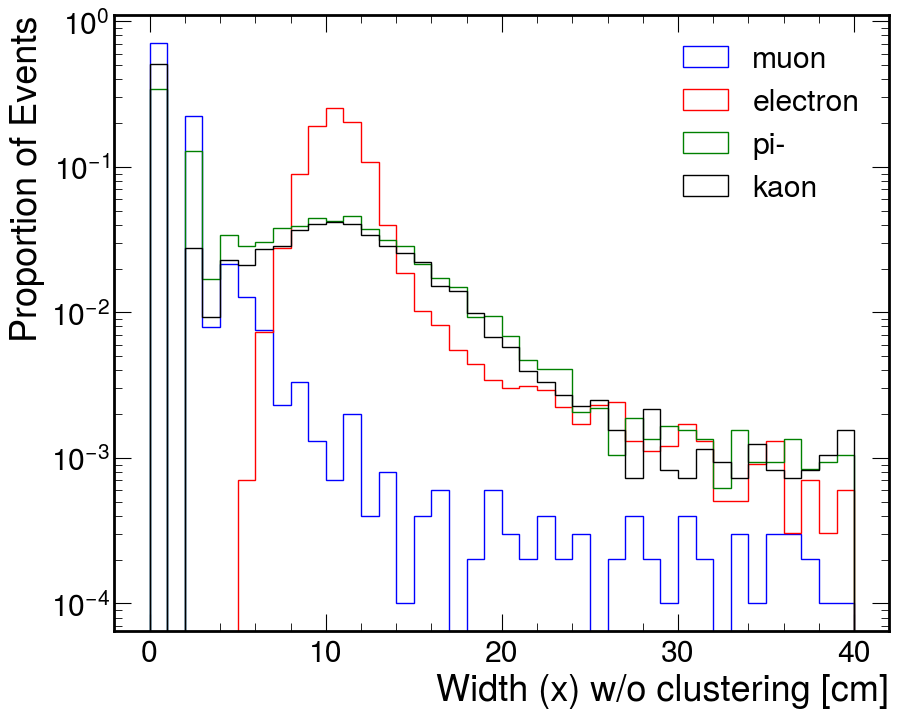

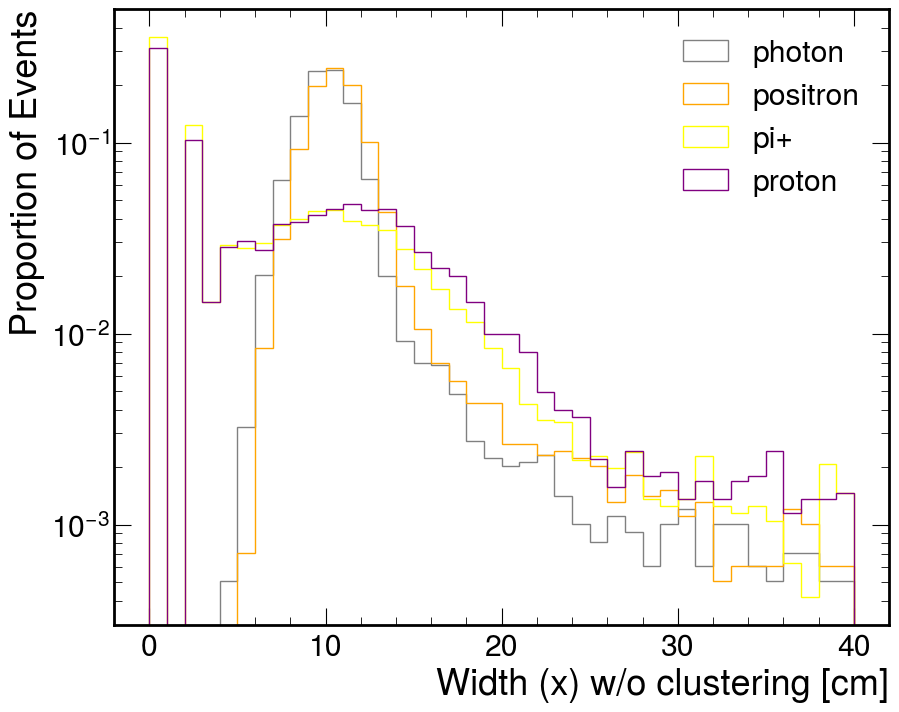

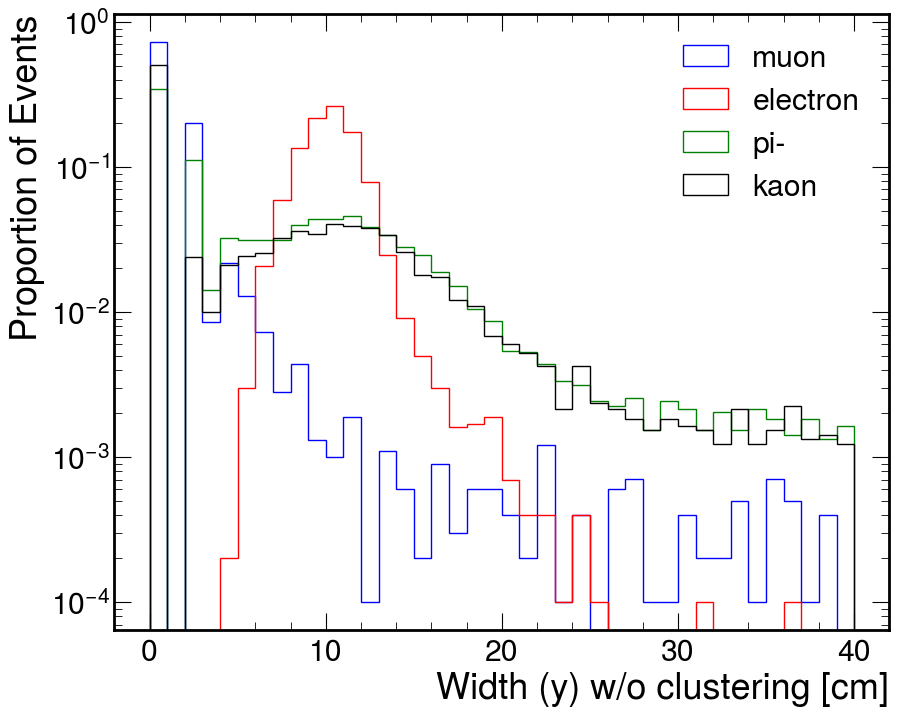

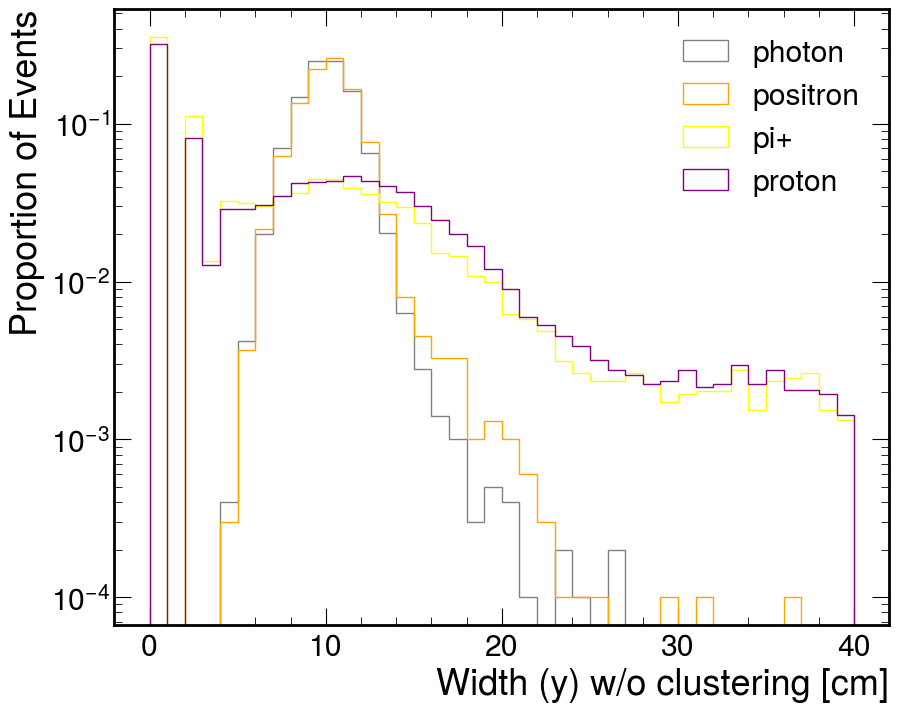

In [42]:
gen_plot()